In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days
file_path = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [2]:
bitcoin_df.shape

(365, 2)

In [3]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


In [5]:
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

In [6]:
# 데이터프레임 index 설정
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

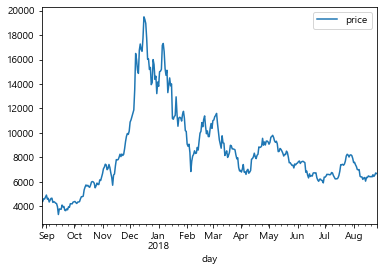

In [7]:
plt.rc('font', family='Malgun Gothic')
bitcoin_df.plot()

In [8]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR = 2, 차분 = 1, MA = 2) 파라미터로 ARIMA 모델을 학습
model = ARIMA(bitcoin_df.price.values, order = (2, 1, 2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Mon, 02 Nov 2020   AIC                           5587.107
Time:                        23:36:42   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3603     27.794      0.229      0.819     -48.115      60.836
ar.L1.D.y     -0.3786      1.823     -0.208      0.836      -3.952       3.195
ar.L2.D.y      0.1587      1.189      0.134      0.894      -2.171       2.488
ma.L1.D.y      0.4567      1.819      0.251      0.802      -3.108       4.022
ma.L2.D.y     -0.1943      1.335     -0.146      0.884      -2.811       2.422
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5864           +0.0000j            1.5864            0.5000
AR.2            3.9715           +0.0000j            3.9715            0.0000
MA.1           -1.3797           +0.0000j            1.3797            0.5000
MA.2            3.7299           +0.0000j            3.7299            0.0000
-----------------------------------------------------------------------------
"""

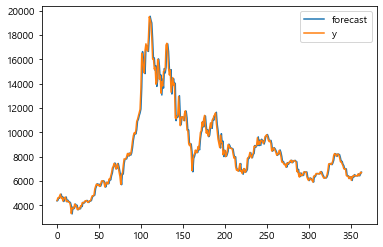

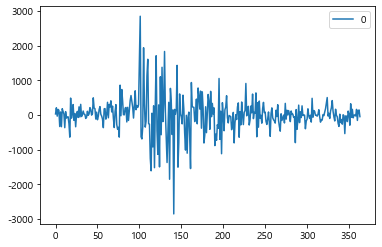

In [9]:
# 모델 성능 & 예측 결과 시각화
fig = model_fit.plot_predict()
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [10]:
# ARIMA 모델 활용하기
forecast_data = model_fit.forecast(steps = 5)

# 테스트 데이터셋을 불러오기
test_file_path = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터 (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최솟값
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최댓값
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

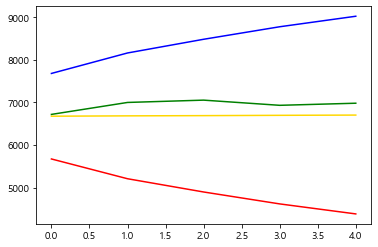

In [11]:
plt.plot(pred_y, color='gold') # 모델이 에측한 가격 그래프
plt.plot(pred_y_lower, color='red') # 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_upper, color='blue') # 모델이 예측한 최고 가격 그래프
plt.plot(test_y, color='green') # 실제 가격 그래프

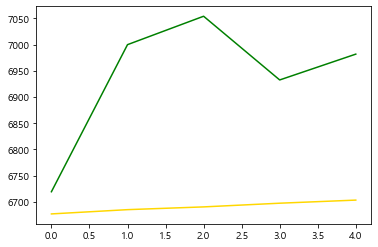

In [12]:
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')

In [14]:
from fbprophet import Prophet

# prophet을 사용하기 위해서는 다음과 같이 피처명 변경이 필요
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative',
                    yearly_seasonality=True,
                     weekly_seasonality=True,
                     daily_seasonality=True,
                     changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [15]:
# 5일을 내다보며 에측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6882.306915,6260.031507,7538.487381
366,2018-08-28,6976.002532,6266.960752,7622.536573
367,2018-08-29,6986.465207,6318.689564,7682.326195
368,2018-08-30,7055.474837,6244.762077,7754.944187
369,2018-08-31,7133.441748,6311.813442,7901.407260


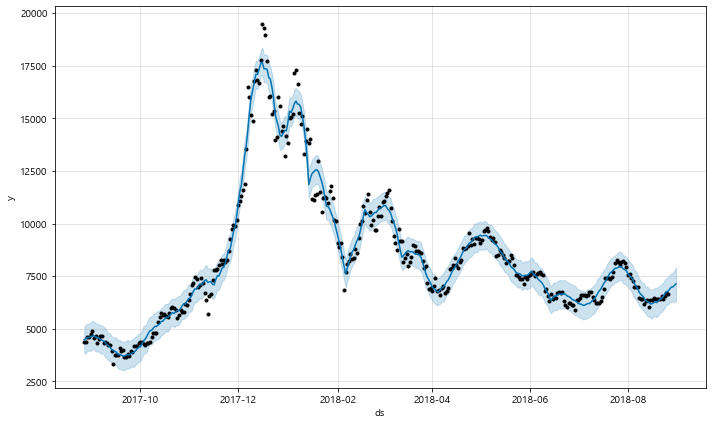

In [16]:
fig1 = prophet.plot(forecast_data)

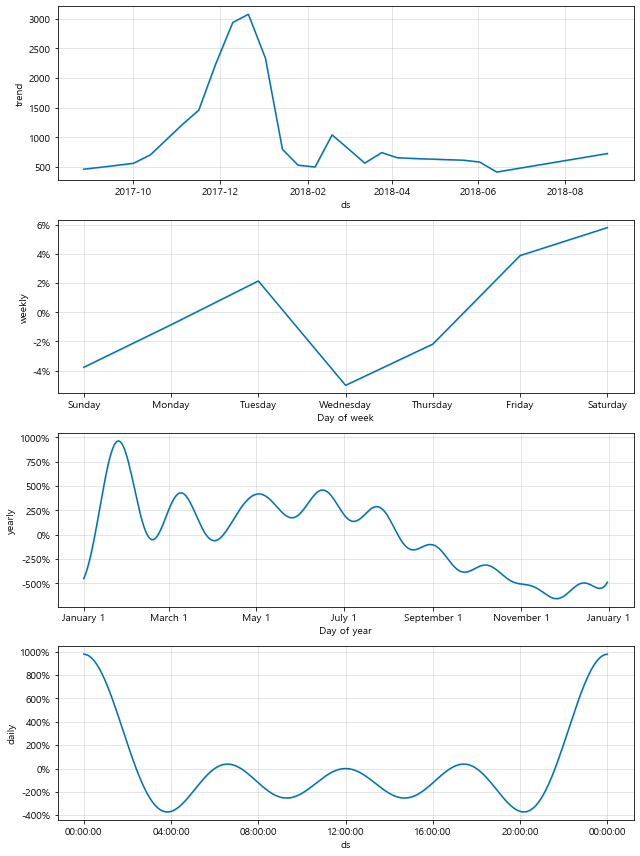

In [17]:
fig2 = prophet.plot_components(forecast_data)

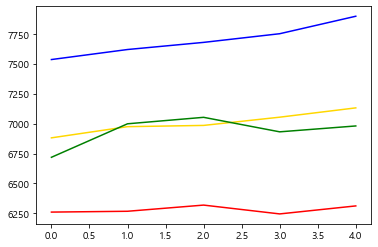

In [18]:
# 실제 데이터와 비교
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 예측 5일 가격 데이터 (2018-08-27 ~ 2018-08-31)
pred_y = forecast_data.yhat.values[-5:]
# 실제 5일 가격 데이터 (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values
# 마지막 5일 예측 최솟값
pred_y_lower = forecast_data.yhat_lower.values[-5:]
# 마지막 5일 예측 최댓값
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color='gold')
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')
plt.plot(test_y, color='green')

In [ ]:
plt.plot(pred_y, color='gold')
plt.plot